In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import spacy

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Ustawnia modelu i sieci

In [4]:
batch_size = 50

In [5]:
torch.cuda.is_available()

True

## Ładowanie danych treningowych

In [6]:
tweets = pd.read_csv('data/olid-training-v1.0.tsv', sep='\t')

In [7]:
tweets.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [8]:
tweets = tweets[:100]

In [9]:
# tweets = tweets[:5]

### Tokenizacja, lematyzacja, usówanie pewnych słów
liczenie najdłuższego przetworzonego tweeta

In [10]:
nlp = spacy.load('en_core_web_sm')

In [11]:
# dodawanie kolumny z tokenami
tweets['tokens'] = tweets['tweet'].apply(nlp)

In [12]:
tweets.head()

,id,tweet,subtask_a,subtask_b,subtask_c,tokens
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,"(@USER, She, should, ask, a, few, native, Amer..."
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"(@USER, @USER, Go, home, you, ’re, drunk, !, !..."
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,"(Amazon, is, investigating, Chinese, employees..."
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,"(@USER, Someone, should'veTaken, "", this, piec..."
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,"(@USER, @USER, Obama, wanted, liberals, &, amp..."


In [13]:
# dodawanie kolumny z lematami za pomoca funkcji lambda - przy tym usuwanie:
# odwolan do wczesniejszych tweetow (zawiera @)
# - slowa url (czyli adresy stron inernetowych które w danych wejściowych mają URL zamiast adreasu.
# # - hasztagów; przyimków i innych częstych słów (stop words) oraz znaków interpunkcyjnych.
# spacji ' ', '  ', '   '

# emotikony zostawiam - uważam, że też niosą znaczenie

tweets['lemmas'] = tweets['tokens'].apply\
    (lambda list_tokens : [token.lemma_.strip() for token in list_tokens if ('@' not in token.lemma_ \
                                                                     and '#' not in token.lemma_ and 'url' not in token.lemma_ \
                                                                     and not token.is_stop and not token.is_punct and token.lemma_ != ' ' \
                                                                     and token.lemma_ != '  ' and token.lemma_ != '   '
                                                                     and token.lemma_ != '    ')])

In [14]:
tweets.loc[:3,'lemmas']

0                             [ask, native, Americans]
1           [home, drunk, MAGA, Trump2020, 👊, 🇺, 🇸, 👊]
2    [Amazon, investigate, chinese, employee, sell,...
3            [should'vetaken, piece, shit, volcano, 😂]
Name: lemmas, dtype: object

In [15]:
tweets.loc[11, 'tokens']

@USER What’s the difference between #Kavanaugh and @USER   One of these men admitted to groping a 15 year old girl years ago.  The other is going to be #confirmed to the SCJ   #DemsareFrauds #DemsAreDone   #WalkAwayDemocrats2018 #redwave #VoteRedSaveAmerica #trumptrain #MAGA URL

In [16]:
tweets['length_lemmas'] = tweets['lemmas'].apply(lambda row: len(row))

In [17]:
tweets.loc[:10, 'length_lemmas']

0      3
1      8
2     18
3      5
4      7
5      2
6      4
7     16
8      2
9     10
10     4
Name: length_lemmas, dtype: int64

In [18]:
max_length_tweet = max(tweets['length_lemmas'])

## Ładowanie danych testowych(a)

In [19]:
test_level_a = pd.read_csv('data/testset-levela.tsv', sep='\t')

In [20]:
labels_level_a = pd.read_csv('data/labels-levela.csv', header=None)

In [21]:
labels_level_a = labels_level_a.rename(columns={0:'id', 1:'subtask_a'})

In [22]:
test_a = pd.merge(test_level_a, labels_level_a, on = "id", how = "inner")

In [23]:
test_a.head()

,id,tweet,subtask_a
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF


In [24]:
len(test_a)

860

### Opracowanie danych testowych (część a)
Takie same modyfikacje jak dla danych treningowych

In [25]:
test_a['tokens'] = test_a['tweet'].apply(nlp)
test_a['lemmas'] = test_a['tokens'].apply \
    (lambda list_tokens : [token.lemma_.strip() for token in list_tokens if ('@' not in token.lemma_ \
                                                                             and '#' not in token.lemma_ and 'url' not in token.lemma_ \
                                                                             and not token.is_stop and not token.is_punct and token.lemma_ != ' ' \
                                                                             and token.lemma_ != '  ' and token.lemma_ != '   ' \
                                                                             and token.lemma_ != '    ')])

test_a['length_lemmas'] = test_a['lemmas'].apply(lambda row: len(row))

In [26]:
max(test_a['length_lemmas'])

40

In [27]:
test_a.head()

,id,tweet,subtask_a,tokens,lemmas,length_lemmas
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,"(#, WhoIsQ, #, WheresTheServer, #, DumpNike, #...","[WhoIsQ, wherestheserver, DumpNike, DECLASFISA...",24
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,"(#, ConstitutionDay, is, revered, by, Conserva...","[ConstitutionDay, revere, conservative, hate, ...",9
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,"(#, FOXNews, #, NRA, #, MAGA, #, POTUS, #, TRU...","[foxnew, NRA, MAGA, POTUS, TRUMP, 2ndamendment...",15
3,13876,#Watching #Boomer getting the news that she is...,NOT,"(#, Watching, #, Boomer, getting, the, news, t...","[watch, Boomer, get, news, parole, make, smile...",10
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,"(#, NoPasaran, :, Unity, demo, to, oppose, the...","[NoPasaran, unity, demo, oppose, far, right, L...",9


In [28]:
len(test_a)

860

In [29]:
max_length_tweet_test = max(test_a['length_lemmas'])

In [30]:
max_length_tweet_test

40

In [31]:
#### Maksymalna długość wektora z lematami z tweetów

In [32]:
max_width = max(max_length_tweet, max_length_tweet_test)

## Funkcje do przekszałcania danych

In [33]:
def convert_words_to_numbers(lemmas_series, dict_ = dict()):
    # dict_ = dict()
    for row in lemmas_series:
        for lemma in row:
            if lemma not in dict_:
                dict_[lemma] = len(dict_) + 1

    return dict_

In [34]:
def lemmas_to_numbers(row, max_list_lemmas, dict_):
    list_numbers = []
    for i in range(max_list_lemmas - len(row)):
        list_numbers.append(0)

    for lemma in row:
        list_numbers.append(dict_[lemma])

    array_numbers = np.array(list_numbers, dtype=np.int32)
    return array_numbers

## Powrót do opracowywania danych treningowych

In [35]:
dict_lemmas = convert_words_to_numbers(tweets['lemmas'])

In [36]:
sorted(dict_lemmas)[:10]

['1', '10', '11th', '15', '2', '2U', '2a', '3', '4', '5/5']

In [37]:
# zamiana lematu na liczbe ze slownika ktory odpowiada danemu slowu
tweets['numbers'] = tweets['lemmas'].apply(lambda row : lemmas_to_numbers(row, max_width, dict_lemmas))

In [38]:
tweets['numbers'].head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: numbers, dtype: object

In [39]:
# przypisywanie X_train kolumny numbers skonwertowanej na tablice numpy
X_train = tweets['numbers'].values

In [40]:
# łączenie wierszy tablic w jedną tablicę 2D
X_train = np.stack(X_train)

In [41]:
# konwertowanie tablicy 2d do tensora
X_train = torch.FloatTensor(X_train)

In [42]:
# ustawianie kolumn z etykietami na poszczególne zadania jako type które przechowują kategorie

In [43]:
cat_cols = ['subtask_a', 'subtask_b', 'subtask_c']

In [44]:
for col in cat_cols:
    tweets[col] = tweets[col].astype('category')

In [45]:
tweets['labels_a'] = tweets['subtask_a'].cat.codes

In [46]:
# OFFENSIVE jest jako 1, a NOT OFFENSIVE jest jako 0
tweets.loc[:5, 'labels_a']

0    1
1    1
2    0
3    1
4    0
5    1
Name: labels_a, dtype: int8

In [47]:
tweets.iloc[0]

id                                                           86426
tweet            @USER She should ask a few native Americans wh...
subtask_a                                                      OFF
subtask_b                                                      UNT
subtask_c                                                      NaN
tokens           (@USER, She, should, ask, a, few, native, Amer...
lemmas                                    [ask, native, Americans]
length_lemmas                                                    3
numbers          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
labels_a                                                         1
Name: 0, dtype: object

In [48]:
y_train = tweets['labels_a'].values

In [49]:
y_train = torch.tensor(y_train).reshape(-1,1)

In [50]:
y_train[:5]

tensor([[1],
        [1],
        [0],
        [1],
        [0]], dtype=torch.int8)

In [51]:
data = np.concatenate((X_train, y_train), axis=1)

In [52]:

train_dataset_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

## Definiowanie modelu

In [53]:
class Model(nn.Module):
    def __init__(self, in_features=18, h1=80, h2=50, out_features=1):
        super().__init__()

        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        # self.sig = nn.Sigmoid()

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # self.out(x)
        x = torch.sigmoid(self.out(x))

        return x

## Opracowywanie danych testowych

In [54]:
dict_lemmas = convert_words_to_numbers(test_a['lemmas'], dict_lemmas)

In [55]:
sorted(dict_lemmas)[:10]

['',
 '$',
 "'cause",
 '+',
 '-AG',
 '-HOMEWARD',
 '-eyesed',
 '-tsk',
 '/attempt/',
 '/via']

In [56]:
# zamiana lematu na liczbe ze slownika ktory odpowiada danemu slowu
test_a['numbers'] = test_a['lemmas'].apply(lambda row : lemmas_to_numbers(row, max_width, dict_lemmas))

In [57]:
test_a['lemmas'].head()

0    [WhoIsQ, wherestheserver, DumpNike, DECLASFISA...
1    [ConstitutionDay, revere, conservative, hate, ...
2    [foxnew, NRA, MAGA, POTUS, TRUMP, 2ndamendment...
3    [watch, Boomer, get, news, parole, make, smile...
4    [NoPasaran, unity, demo, oppose, far, right, L...
Name: lemmas, dtype: object

In [58]:
test_a.loc[:5, 'numbers']

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: numbers, dtype: object

### Robienie tego samego procesu co wcześniej dla danych testowych


In [59]:
X_test = test_a['numbers'].values


In [60]:
X_test = np.stack(X_test)

In [61]:
X_test = torch.FloatTensor(X_test)

In [62]:
# cat_cols = ['subtask_a', 'subtask_b', 'subtask_c']
# for col in cat_cols:
#     X_test[col] = X_test[col].astype('category')

In [63]:
test_a['subtask_a'] = test_a['subtask_a'].astype('category')

In [64]:
test_a['labels_a'] = test_a['subtask_a'].cat.codes

In [65]:
# OFFENSIVE jest jako 1, a NOT OFFENSIVE jest jako 0
test_a.loc[:5, 'labels_a']

0    1
1    0
2    0
3    0
4    1
5    1
Name: labels_a, dtype: int8

In [66]:
y_test = test_a['labels_a'].values

In [67]:
y_test = torch.tensor(y_test).reshape(-1,1)

In [68]:
y_test[:5]

tensor([[1],
        [0],
        [0],
        [0],
        [1]], dtype=torch.int8)

In [69]:
data_test_a = np.concatenate((X_test, y_test), axis=1)

In [70]:

test_dataset_loader_a = torch.utils.data.DataLoader(data_test_a, batch_size=batch_size, shuffle=True)

## Tworzenie instancji modelu
Ustawianie funkcji straty i optymalizatora

In [71]:
# tworzenie numpy array z listy liczb (odpowiadających lematom)

In [72]:
torch.manual_seed(32)
model = Model(max_width)

In [73]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Ustawianie nauki sieci i samo uczenie się

In [74]:
epochs = 100
losses = []
losses_test = []
accuracy = []
accuracy_test = []
train_count = len(tweets)
test_count_a = len(test_a)

In [75]:
for e in range(epochs):
    loss_epoch = np.empty(0)
    correct_epoch = 0

    loss_epoch_test = np.empty(0)
    correct_epoch_test = 0

    for batch_num, batch in enumerate(train_dataset_loader):
        X_train = batch[:,:-1]
        y_train = batch[:,-1].reshape(-1,1)
        y_pred = model.forward(X_train)

        loss = criterion(y_pred, y_train)
        if (e == 0 and batch_num == 0):
            print(f'Loss on the first batch: {loss}')

        # print(loss.item())
        loss_epoch = np.append(loss_epoch, loss.detach().numpy())
        # losses.append(loss.item())


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        predicted = torch.round(y_pred)
        # print(predicted)
        # print(y_train)
        predicted = (predicted == y_train).sum()
        # print(f'Predicted this batch: {predicted}')
        correct_epoch += predicted

# przechodzenie przez dane testowe
    with torch.no_grad():
        for batch_num, batch in enumerate(test_dataset_loader_a):
            X_test = batch[:,:-1]
            y_test = batch[:,-1].reshape(-1,1)
            y_pred = model.forward(X_test)

            loss = criterion(y_pred, y_test)
            if (e == 0 and batch_num == 0):
                print(f'Loss on the first batch on test data: {loss}')

            # print(loss.item())
            loss_epoch_test = np.append(loss_epoch_test, loss.detach().numpy())
            # losses.append(loss.item())

            predicted = torch.round(y_pred)
            # print(predicted)
            # print(y_test)
            predicted = (predicted == y_test).sum()
            # print(f'Predicted this batch: {predicted}')
            correct_epoch_test += predicted

        loss_epoch_test = loss_epoch_test.sum() / test_count_a
        losses_test.append(loss_epoch)
        accuracy_epoch_test = correct_epoch_test * 100/test_count_a
        accuracy_test.append(accuracy_epoch_test)

    loss_epoch = loss_epoch.sum() / train_count
    losses.append(loss_epoch)
    accuracy_epoch = correct_epoch * 100/train_count
    accuracy.append(accuracy_epoch)

    # print(f'Test accuracy: {correct_epoch.item()}/{train_count} = {correct.item() * 100 / (test_count):7.3f}%')
    print(f' epoch: {e} | loss: {loss_epoch} | predicted: {correct_epoch} | accuracy: {accuracy_epoch} | test loss: {loss_epoch_test} | ' \
          + f'predicted: {correct_epoch_test} | test accuracy: {accuracy_epoch_test}')

Loss on the first batch: 40.87933349609375
Loss on the first batch on test data: 47.458641052246094
 epoch: 0 | loss: 0.7033251190185547 | predicted: 33 | accuracy: 33.0 | test loss: 0.9905464172363281 | predicted: 356 | test accuracy: 41.395347595214844
 epoch: 1 | loss: 0.1637565851211548 | predicted: 46 | accuracy: 46.0 | test loss: 0.4558910569479299 | predicted: 553 | test accuracy: 64.30232238769531
 epoch: 2 | loss: 0.04538987159729004 | predicted: 58 | accuracy: 58.0 | test loss: 0.4062153827312381 | predicted: 616 | test accuracy: 71.6279067993164
 epoch: 3 | loss: 0.05936400651931763 | predicted: 67 | accuracy: 67.0 | test loss: 0.4506370954735335 | predicted: 618 | test accuracy: 71.86046600341797
 epoch: 4 | loss: 0.06849943161010742 | predicted: 68 | accuracy: 68.0 | test loss: 0.4624277203582054 | predicted: 618 | test accuracy: 71.86046600341797
 epoch: 5 | loss: 0.0628628134727478 | predicted: 68 | accuracy: 68.0 | test loss: 0.414200142926948 | predicted: 618 | test ac

In [ ]:
y_val

In [ ]:
torch.round(y_val)

## Rysowanie funkcji straty i accuracy na przestrzeni epok

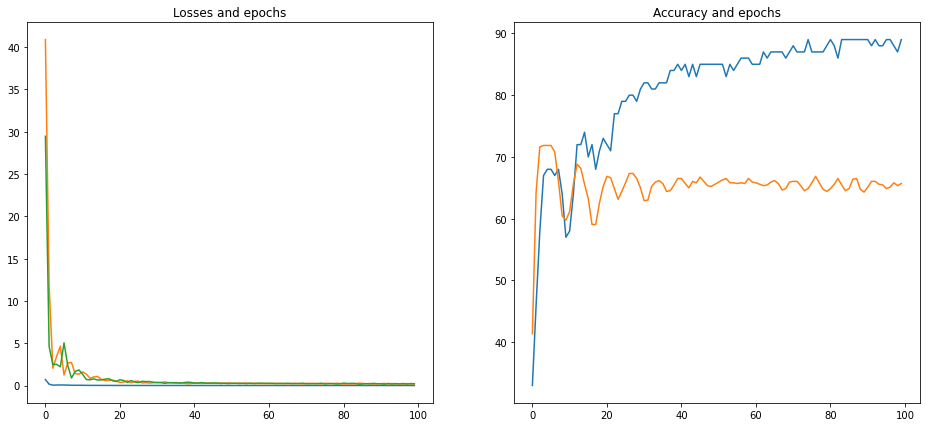

In [77]:
## Plot loss functions over epochs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
# ax1.plot(x, y)
# ax2.plot(x, -y)

# fig, axis = plt.subplots(1, 2, figsize=(10,7))
#
# axis[0, 0].plot(range(epochs), losses)
# axis[0, 0].set_title("Losses and epochs")
#
# axis[0, 1].plot(range(epochs), accuracy)
# axis[0, 1].set_title("Accuracy and epochs")

ax1.plot(range(epochs), losses)
ax1.plot(range(epochs), losses_test)
ax1.set_title('Losses and epochs')

ax2.plot(range(epochs), accuracy)
ax2.plot(range(epochs), accuracy_test)
ax2.set_title("Accuracy and epochs")

plt.show()